***Library import***

In [81]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from statistics import mean

In [45]:
import importlib.util
spec = importlib.util.spec_from_file_location("module.name", r"C:\Users\BrechtDewilde\Documents\Python Scripts\Data Science Module\bd_ds_module.py")
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

In [42]:
dir(mod)

['LinearRegression',
 'PolynomialFeatures',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_tree',
 'mean_absolute_error',
 'mean_squared_error',
 'pd',
 'plt',
 'poly_optimal_degree_determiner',
 'r2_score',
 'train_test_split',
 'tree_to_rules']

### Predicting baseball players' salaries using Regression Trees

In [20]:
data = pd.read_csv(r"C:\Users\BrechtDewilde\Documents\UGENT -  statistical data analysis\STATISTICAL DATA ANALYSIS\SEM 2\Big data science\datasets\hitters.csv" )
data.columns = data.columns[1:].insert(0, "Player")
data.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


### Simple decision tree

To gain an idea of the performance, create a tree with depth 2 only using hits and years as features.

In [51]:
data_subset = data.loc[:,["Hits", "Years", "Salary"]].dropna()
x = data_subset.loc[:,["Hits","Years"]]
y = data_subset.loc[:,"Salary"]
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 0, test_size = 0.2)

In [53]:
# creating the model
regressor = DecisionTreeRegressor(random_state=0, max_depth = 2)
tree = regressor.fit(x_train,y_train)
y_pred = tree.predict(x_test)

In [54]:
# obtain an idea of the created decision rules
mod.tree_to_rules(tree, ["Hits", "Years"])

def tree(Hits, Years):
  if Years <= 4.5:
    if Hits <= 14.0:
      return [[2127.333]]
    else:  # if Hits > 14.0
      return [[192.05072464]]
  else:  # if Years > 4.5
    if Hits <= 117.5:
      return [[434.20291304]]
    else:  # if Hits > 117.5
      return [[912.03721127]]


In [56]:
# what is the performance of the model
mean_squared_error(y_test, y_pred)

214174.59764371673

This is very very large, obviously a tree of depth 2 is not complex, thus a lot of bias is introduced. <br/>What is the performance, in case we build a full tree?

In [60]:
regressor = DecisionTreeRegressor(random_state=0)
tree = regressor.fit(x_train,y_train)
y_pred = tree.predict(x_test)

In [61]:
mean_squared_error(y_test, y_pred)

279196.4906903963

This is interesting! The mse is even larger, indicating that we are now overfitting the training data. This is characteristic of decision trees. <br/>Let's see whether we are able to find the depth whith the least test error.

**What is the best depth?** <br/> It should be between 2 and 17.

In [66]:
x = data_subset.loc[:,["Hits","Years"]]
y = data_subset.loc[:,"Salary"]

In [78]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [106]:
mse_list = []
for depth in range(2, 18):
    regressor = DecisionTreeRegressor(random_state=0, max_depth = depth)
    mse_list.append(mean(abs(cross_val_score(regressor, x, y, cv = 5, scoring = "neg_mean_squared_error"))))

In [108]:
mean(mse_list)

191794.29028030456

Text(0.5, 1.0, 'Test error evolution')

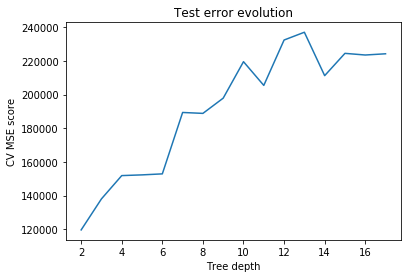

In [89]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(list(range(2,18)), mse_list)
ax.set_xlabel("Tree depth")
ax.set_ylabel("CV MSE score")
ax.set_title("Test error evolution")

**Conclusion**: with the creation of a simple tree, we still have a very bad performance. Increasing the depth, only makes the tree overfit the training data. Next, we will check wether the performance can be enhanced by applying a pruning algorithm. 

### Pruning algorithm

In [94]:
regressor = DecisionTreeRegressor(random_state=0, presort = True)

### Ensemble learners

***Bagging***

In [95]:
from sklearn.ensemble import BaggingRegressor

In [105]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 0, test_size = 0.2)
regr = BaggingRegressor(base_estimator = DecisionTreeRegressor(random_state=0, max_depth = 2), n_estimators = 10).fit(x_train, y_train)
y_pred = regr.predict(x_test)

187206.41371755465

In [109]:
mean_squared_error(y_test, y_pred)

187206.41371755465

It seems that bagging with default features is already an improvement. However, increasing the number of created trees should decrease this.

In [127]:
mse_list = []
for i in range(10, 500):
    regr = BaggingRegressor(base_estimator = DecisionTreeRegressor(random_state=0, max_depth = 2), n_estimators = 10).fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    mse_list.append(mean_squared_error(y_test, y_pred))

Text(0.5, 1.0, 'Influence of the number of trees in a bagging algorithm')

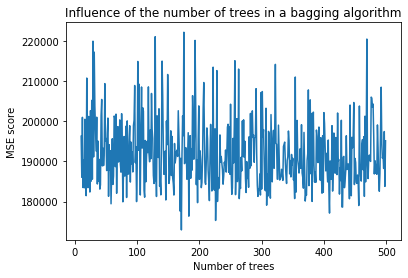

In [128]:
fig, ax = plt.subplots()
ax.plot(list(range(10,500)), mse_list)
ax.set_xlabel("Number of trees")
ax.set_ylabel("MSE score")
ax.set_title("Influence of the number of trees in a bagging algorithm")

There is not a clear pattern visible. Meaning, that increasing the number of trees is not benificial.

***Random Forest***

In [122]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth = 1, n_estimators = 10).fit(x_train, y_train)
y_pred = regr.predict(x_test)
mean_squared_error(y_test, y_pred)

218703.33037065886

This is very high, compared to the other models. However, we are only using 10 trees in our forest. By increasing this amount of trees, the error will decrease.

In [123]:
mse_list = []
for i in range(10, 500):
    regr = RandomForestRegressor(max_depth = 1, n_estimators = i).fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    mse_list.append(mean_squared_error(y_test, y_pred))

Text(0.5, 1.0, 'Number of trees')

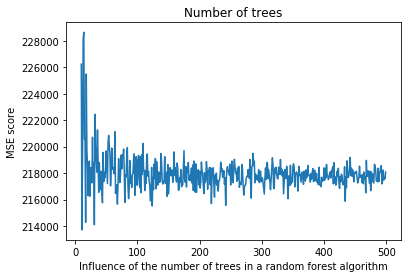

In [124]:
fig, ax = plt.subplots()
ax.plot(list(range(10,500)), mse_list)
ax.set_xlabel("Number of trees")
ax.set_ylabel("MSE score")
ax.set_title("Influence of the number of trees in a random forest algorithm")

It seems that the random forest algorithm performs worse then the bagging algorithm. Witch is surprising. 

***Boosting***

In [131]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state=0, n_estimators=100, base_estimator = DecisionTreeRegressor(random_state=0, max_depth = 2))
regr = regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

In [132]:
mean_squared_error(y_test, y_pred)

168845.24463169128

This is the best result yet! And the amount of trees can still be increased. However, boosting algorithms are dangerous to overfit. Therefore cross-validation is used to determine the best value.

In [152]:
boosting_score = []
for amount in range(10, 50):
    regr = AdaBoostRegressor(random_state=0, n_estimators=amount, base_estimator = DecisionTreeRegressor(random_state=0, max_depth = 2))
    boosting_score.append(mean(cross_val_score(regr, x_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))

Text(0.5, 1.0, 'Influence of the number of trees in the boosting algorithm')

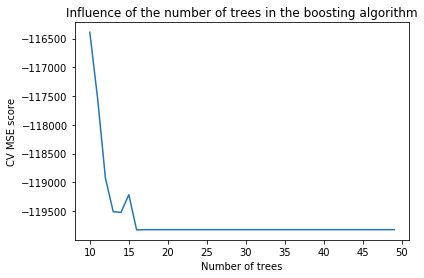

In [153]:
fig, ax = plt.subplots()
ax.plot(list(range(10,50)), boosting_score)
ax.set_xlabel("Number of trees")
ax.set_ylabel("CV MSE score")
ax.set_title("Influence of the number of trees in the boosting algorithm")